In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt 
from visualisation.topograph import get_psds, plot_topomap

In [20]:
subjects_dir = os.path.join("inria-bci-challenge", "train")
subject = os.listdir(subjects_dir)[1]
col_names = pd.read_csv(os.path.join(subjects_dir, subject)).columns
col_names = [col for col in col_names][1:-2]
print(col_names)

['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'POz', 'P08', 'O1', 'O2']


In [3]:
data_dir = os.path.join("inria-bci-challenge", "features", "raw_data", "train")
path = os.path.join(data_dir, "features.npy")
raw_data = np.load(path)[:, :, :-1].transpose(0, 2, 1) * 1e-6
# raw_data = raw_data[:, index, :]

In [5]:
path_labels = os.path.join(data_dir, "labels.npy")
labels = np.load(path_labels)

In [6]:
def access_patient(raw_data, labels, patient_id):
    reshaped_data = raw_data.reshape(13, 340, 56, 256)
    reshaped_labels = labels.reshape(13, 340)
    patient_data, patient_labels = reshaped_data[patient_id - 1], reshaped_labels[patient_id - 1]
    return patient_data, patient_labels


def access_patient_session(raw_data, labels, patient_id, session_id):
    reshaped_data = raw_data.reshape(13, 340, 56, 256)
    reshaped_labels = labels.reshape(13, 340)
    patient_data, patient_labels = reshaped_data[patient_id - 1], reshaped_labels[patient_id - 1]
    if session_id == 5:
        return patient_data[240:], patient_labels[240:]
    else:
        first_idx = 60 * (session_id - 1)
        last_idx = 60 * (session_id)
        return patient_data[first_idx: last_idx], patient_labels[first_idx: last_idx]
    

def split_negative_feedback(patient_data, patient_labels):
    pos_idx = np.where(patient_labels == 1)[0]
    neg_idx = np.where(patient_labels == 0)[0]
    return patient_data[pos_idx], patient_data[neg_idx]

In [7]:
def difference_negative_positive(raw_data, labels, patient_id, session_id):
    patient_data, patient_labels = access_patient_session(raw_data, labels, patient_id, session_id)
    pos_sample, neg_sample = split_negative_feedback(patient_data, patient_labels)
    mean_positive_sample = np.mean(pos_sample, axis=0)
    mean_negative_sample = np.mean(neg_sample, axis=0)
    
    # Plot
    ch_data1 = mean_positive_sample
    ch_data2 = mean_negative_sample
    pwrs1, _ = get_psds(ch_data1)
    pwrs2, _ = get_psds(ch_data2)
    
    font = {'fontname':'Times', 'fontsize': 20, 'pad': 50.0}
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    fig.suptitle(f"EEG Topograph - Patient {patient_id} - Session {session_id}", 
                 fontname='Times', 
                 fontsize= 25,
                y=1.15)
    plot_topomap(pwrs1, ax[0], fig)
    ax[0].set_title("Positive Feedback", **font)
    plot_topomap(pwrs2, ax[1], fig)
    ax[1].set_title("Negative Feedback", **font)
    plt.show()
    
    pass

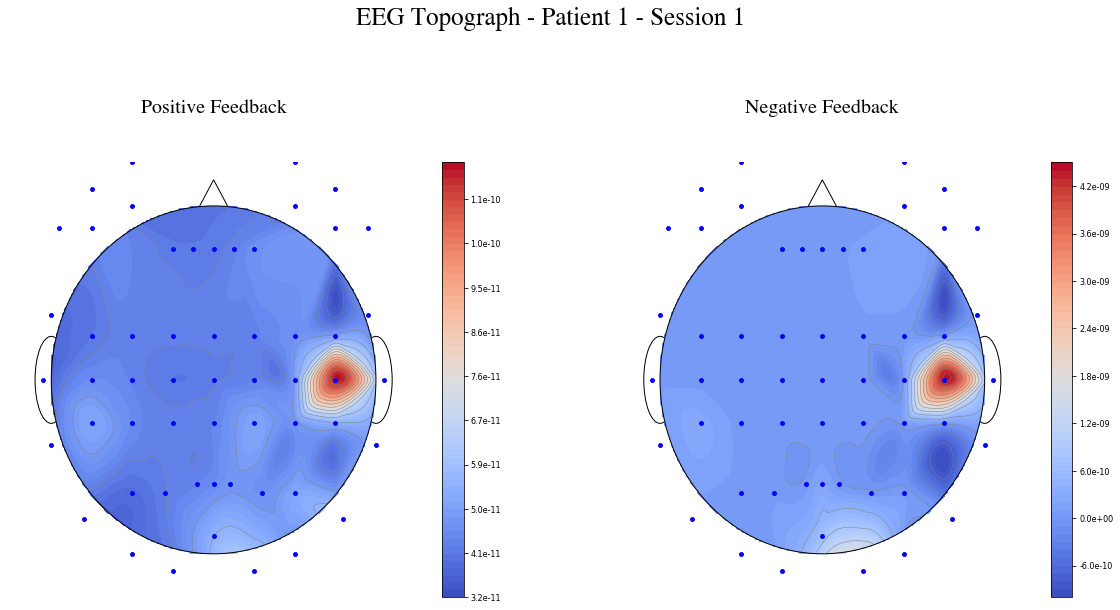

In [15]:
difference_negative_positive(raw_data, labels, patient_id=1, session_id=1)

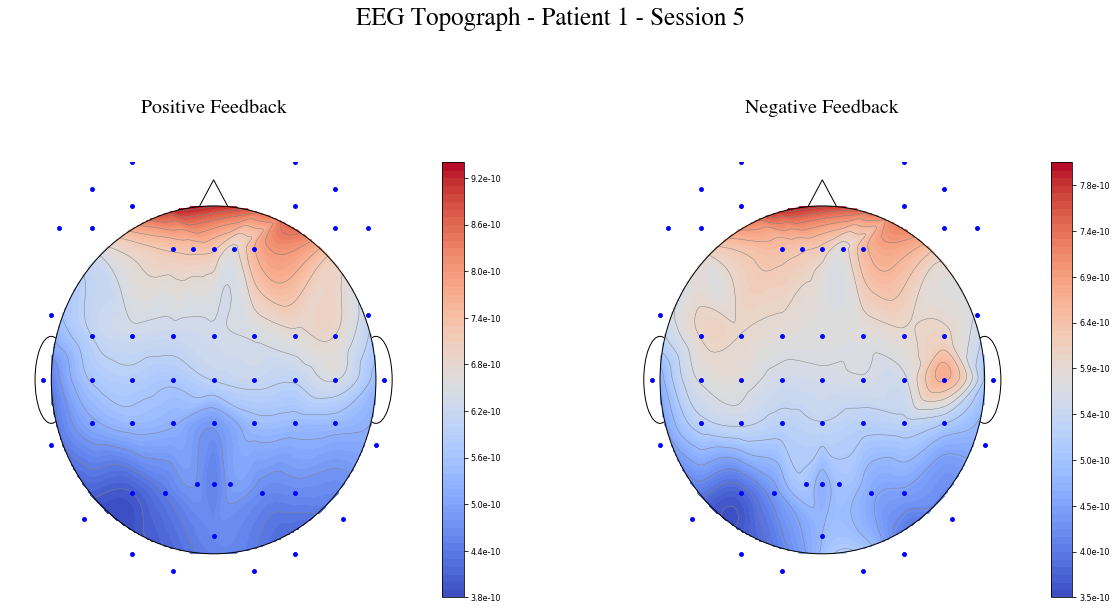

In [21]:
difference_negative_positive(raw_data, labels, patient_id=1, session_id=5)

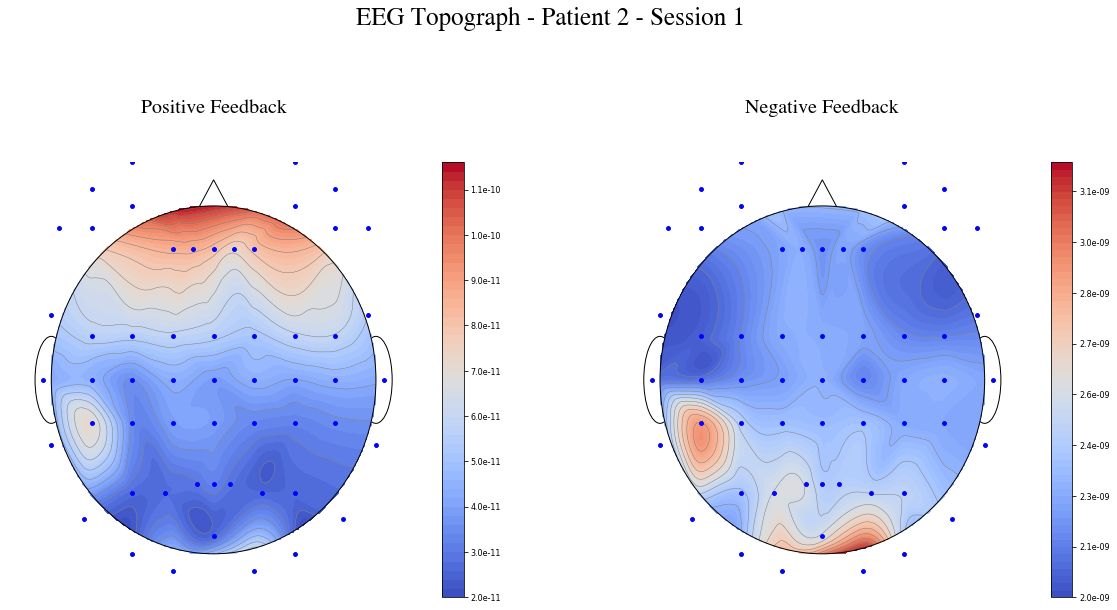

In [41]:
difference_negative_positive(raw_data, labels, patient_id=2, session_id=1)

In [16]:
def draw_plot(raw_data, labels, patient_id, session_id, channel_id, col_names=col_names):
    patient_data, patient_labels = access_patient_session(raw_data, labels, patient_id, session_id)
    pos_sample, neg_sample = split_negative_feedback(patient_data, patient_labels)
    
    # Mean
    mean_positive_sample = np.mean(pos_sample[:, channel_id, :], axis=0)
    mean_negative_sample = np.mean(neg_sample[:, channel_id, :], axis=0)
    
    # Standard error
    std_positive_sample = 1.96 * np.std(pos_sample[:, channel_id, :], axis=0) / pos_sample.shape[0]
    std_negative_sample = 1.96 * np.std(neg_sample[:, channel_id, :], axis=0) / neg_sample.shape[0]
    
    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot(mean_positive_sample, color='b', label="Positive Samples")
    plt.plot(mean_negative_sample, color='r', label="Negative Samples")
    plt.fill_between(np.arange(0, 256), mean_positive_sample - std_positive_sample, mean_positive_sample + std_positive_sample, 
                     color='b', alpha=.2)
    plt.fill_between(np.arange(0, 256), mean_negative_sample - std_negative_sample, mean_negative_sample + std_negative_sample, 
                     color='r', alpha=.2)
    
    plt.xlabel("Time")
    plt.ylabel(r"$\mu$ V")
    plt.legend()
    
    if session_id == 5:
        trials = 100
    else:
        trials = 60
    plt.title(f"Patient {patient_id} - Session {session_id} - Mean of channel {col_names[channel_id]} over {trials} trials", 
              pad=30, font="Times", fontsize=30)
    
    plt.show()
    
    pass



def draw_plot_patient(raw_data, labels, patient_id, channel_id, col_names=col_names):
    patient_data, patient_labels = access_patient(raw_data, labels, patient_id)
    pos_sample, neg_sample = split_negative_feedback(patient_data, patient_labels)
    
    # Mean
    mean_positive_sample = np.mean(pos_sample[:, channel_id, :], axis=0)
    mean_negative_sample = np.mean(neg_sample[:, channel_id, :], axis=0)
    
    # Standard error
    std_positive_sample = 1.96 * np.std(pos_sample[:, channel_id, :], axis=0) / pos_sample.shape[0]
    std_negative_sample = 1.96 * np.std(neg_sample[:, channel_id, :], axis=0) / neg_sample.shape[0]
    
    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot(mean_positive_sample, color='b', label="Positive Samples")
    plt.plot(mean_negative_sample, color='r', label="Negative Samples")
    plt.fill_between(np.arange(0, 256), mean_positive_sample - std_positive_sample, mean_positive_sample + std_positive_sample, 
                     color='b', alpha=.2)
    plt.fill_between(np.arange(0, 256), mean_negative_sample - std_negative_sample, mean_negative_sample + std_negative_sample, 
                     color='r', alpha=.2)
    
    plt.xlabel("Time")
    plt.ylabel(r"$\mu$ V")
    plt.legend()
    
    plt.title(f"Patient {patient_id} - Mean of channel {col_names[channel_id]} over 340 trials", 
              pad=30, font="Times", fontsize=30)
    
    plt.show()
    
    pass

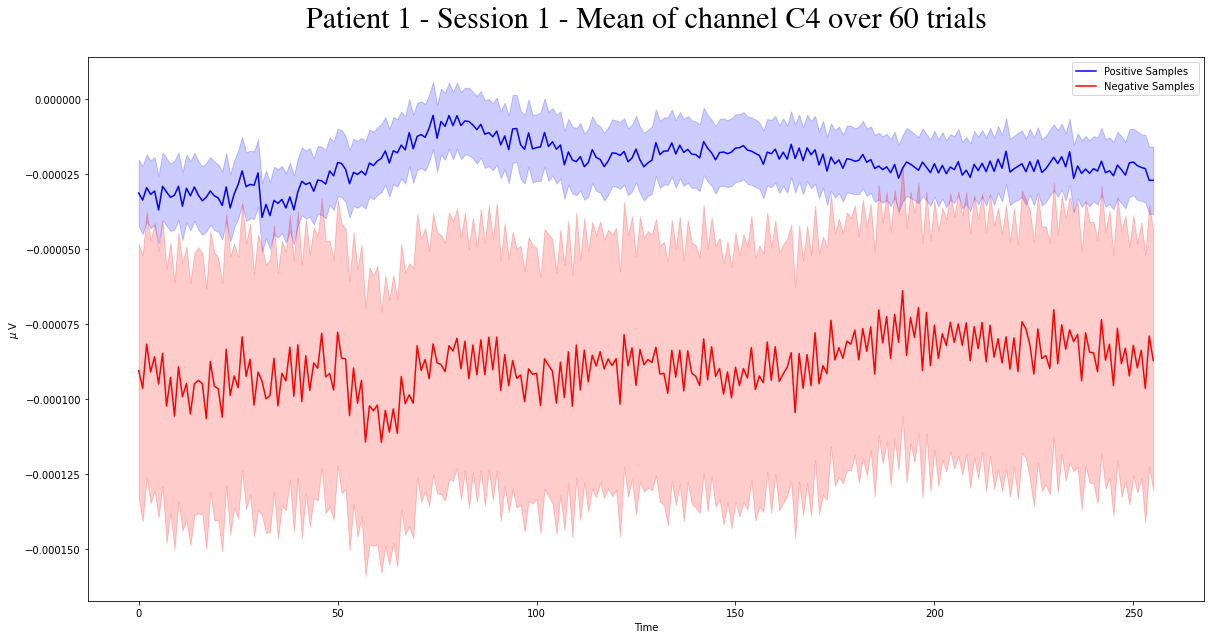

In [52]:
draw_plot(raw_data, labels, patient_id=1, session_id=1, channel_id=30)

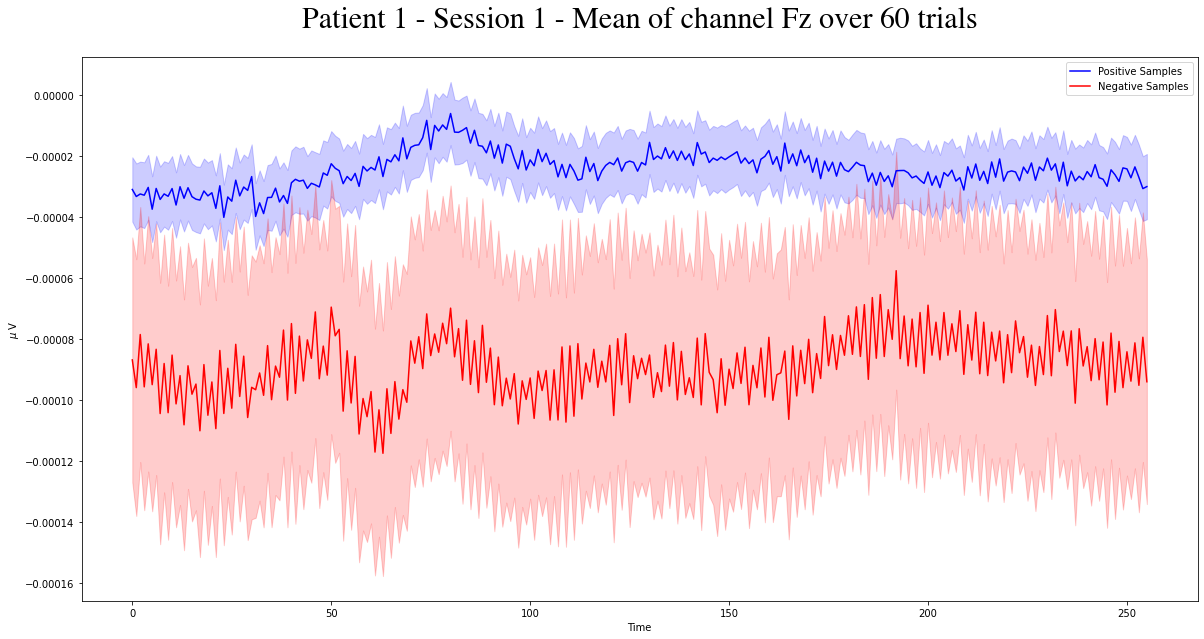

In [45]:
draw_plot(raw_data, labels, patient_id=1, session_id=1, channel_id=10)

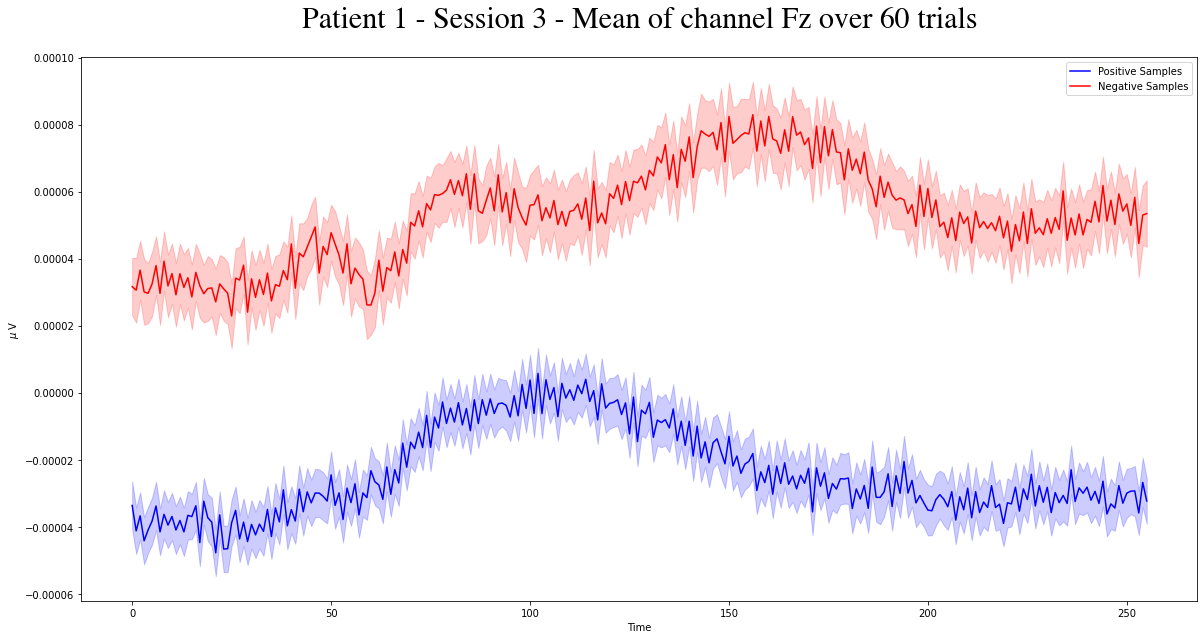

In [29]:
draw_plot(raw_data, labels, patient_id=1, session_id=3, channel_id=10)

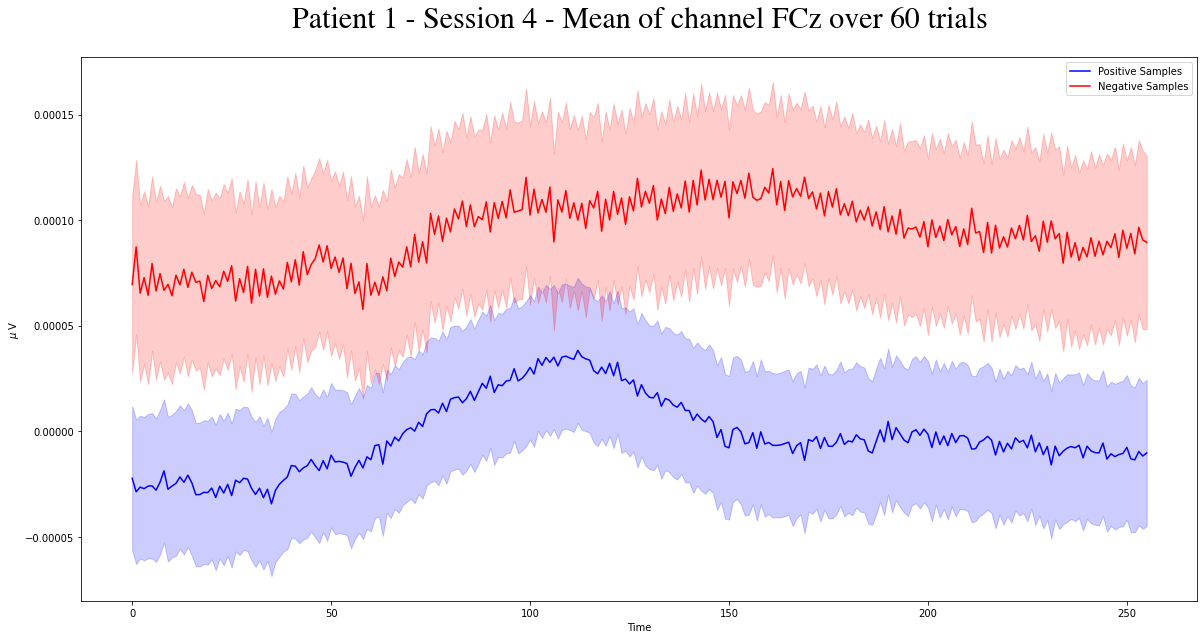

In [31]:
draw_plot(raw_data, labels, patient_id=1, session_id=4, channel_id=19)

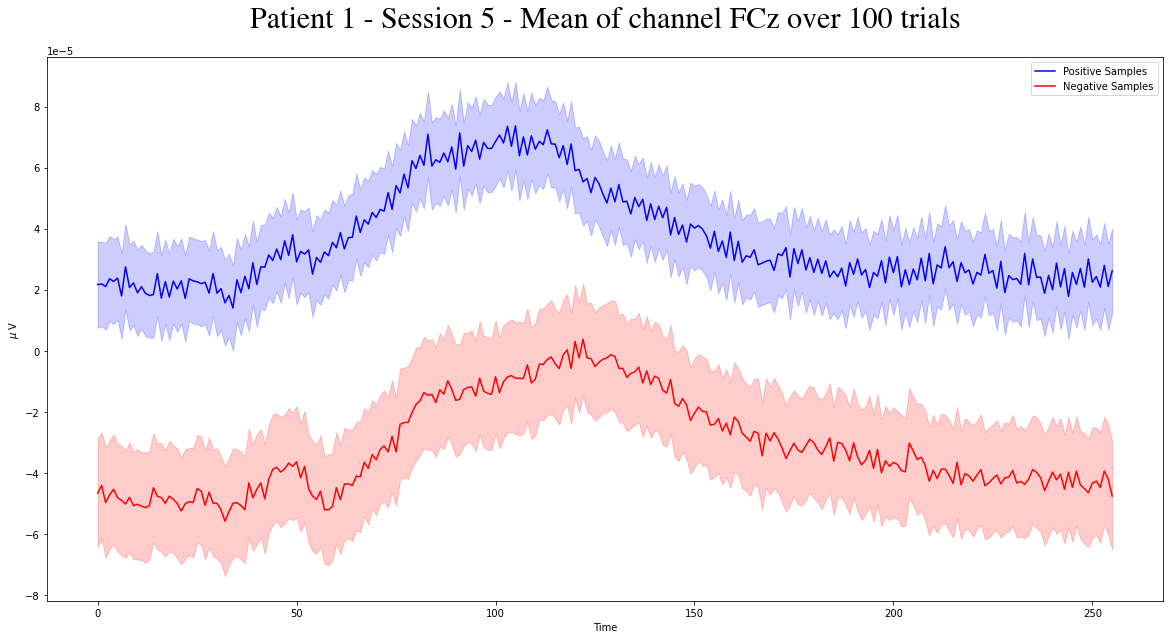

In [33]:
draw_plot(raw_data, labels, patient_id=1, session_id=5, channel_id=19)

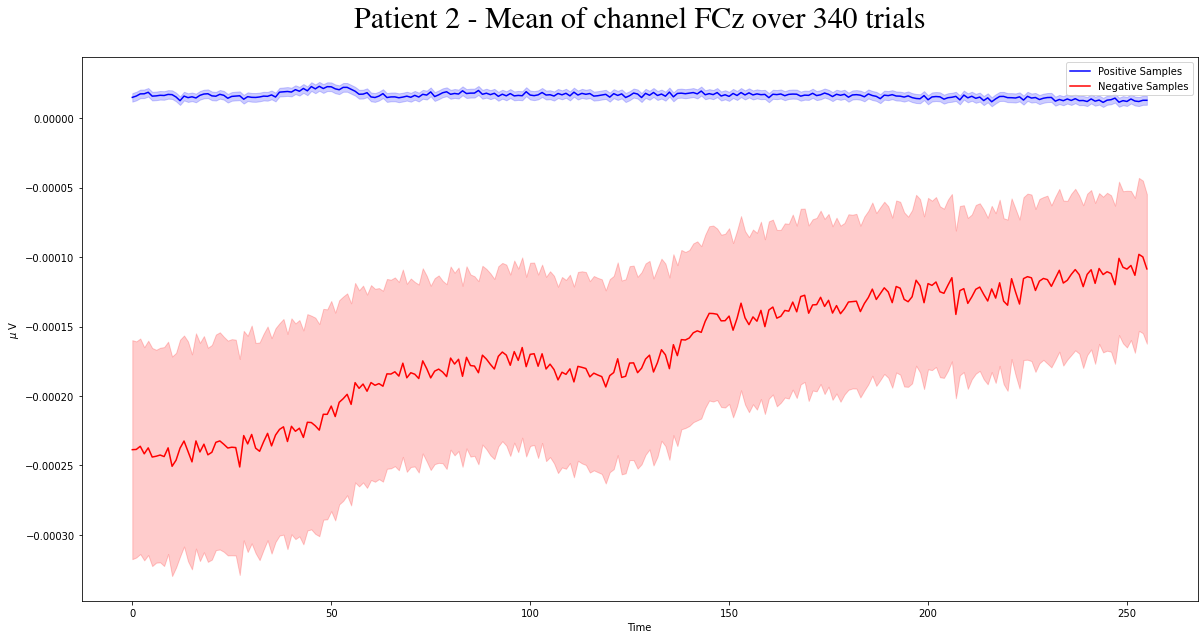

In [60]:
draw_plot_patient(raw_data, labels, patient_id=2, channel_id=19)